In [ ]:
!pip install datasets openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are install

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
import torch
from datasets import load_dataset
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
# suppress sklearn warning
import warnings; warnings.filterwarnings("ignore")
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

In [ ]:
# Importing the numpy library to perform mathematical operations
import numpy as np

# Define a function to run the fine-tuned model and get the model's response
def run_ft_model(review, ft_id, system='', chat=False, **kwargs):
    # Use OpenAI's API to create a completion using the fine-tuned model
    if chat:
        completion = client.chat.completions.create(
            model=ft_id,
            messages=[
                {"role": "system", "content": system},
                {"role": "user", "content": review}
            ] if system else [{"role": "user", "content": review}],
            max_tokens=1,
            logprobs=True,                 # Request logprobs
            top_logprobs=20,               # Request the top 20 log probabilities for the completion,
            **kwargs
        )
        text = completion.choices[0].message.content.strip()
        logprobs = completion.choices[0].logprobs.content[0].top_logprobs
        return text, {logprob.token: np.round(np.exp(logprob.logprob),5) for logprob in logprobs}
    else:
        completion = client.completions.create(
            model=ft_id,                   # Specify the fine-tuned model ID
            prompt=review,                 # Format the review with the prompt structure
            max_tokens=1,                  # Limit the response to 1 token (useful for classification tasks)
            logprobs=20,                   # Request logprobs

        )

        # Extract the model's completion text and strip any extra whitespace
        text = completion.choices[0].text.strip()

        # Convert the log probabilities to regular probabilities using the exponential function
        # This provides a clearer understanding of the model's confidence in its responses
        probs = {k: np.exp(v) for k, v in completion.choices[0].logprobs.top_logprobs[-1].items()}

        return text, probs

In [ ]:
# babbage for one epoch
run_ft_model('I hated it\n###\n', 'ft:babbage-002:personal::9PVvOEA2')

('0',
 {'0': 0.6913066337680023,
  '4': 0.18054803765941707,
  '1': 0.07534118109321017,
  '2': 0.030275447756724812,
  '3': 0.022176032287717223})

In [ ]:
# gpt-3.5 no system prompt
run_ft_model('I hated it\n###\n', 'ft:gpt-3.5-turbo-0125:personal::9PdLZ86e', chat=True, system='')

('0',
 {'0': 0.84944,
  '4': 0.07308,
  '1': 0.04314,
  '2': 0.0213,
  '3': 0.01293,
  '5': 3e-05,
  '8': 1e-05,
  '7': 1e-05,
  '9': 1e-05,
  '6': 1e-05,
  '00': 0.0,
  '10': 0.0,
  '01': 0.0,
  '100': 0.0,
  '000': 0.0,
  '-': 0.0,
  ' ': 0.0,
  '04': 0.0,
  '02': 0.0,
  '20': 0.0})

In [ ]:
run_ft_model(
    'Please classify this app review with 0-4 where 0 means they hated it, 2 means they kind of liked it, and 4 means they loved it.\n\ntReiew: I hated it\nStar Rating:',
    'gpt-3.5-turbo-0125', chat=True, system='')

('0',
 {'0': 0.99859,
  ' ': 0.00112,
  '1': 6e-05,
  '-': 4e-05,
  'Rating': 3e-05,
  'I': 2e-05,
  '\n': 2e-05,
  'This': 1e-05,
  '\n\n': 1e-05,
  'Given': 1e-05,
  'Rated': 1e-05,
  'The': 1e-05,
  'Star': 1e-05,
  'It': 0.0,
  ' \n\n': 0.0,
  '(': 0.0,
  'Score': 0.0,
  'Review': 0.0,
  ' \n': 0.0,
  '2': 0.0})

In [ ]:
from datasets import ClassLabel
dataset = load_dataset('app_reviews', split='train')
dataset = dataset.class_encode_column('star')
dataset

Generating train split:   0%|          | 0/288065 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/288065 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/288065 [00:00<?, ? examples/s]

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [ ]:
SEED = 42
dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')
dataset['train'] = df['train']
dataset['val'] = df['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [ ]:
len(dataset['test'])

57613

In [ ]:
test_sample = dataset['test'].train_test_split(test_size=.1, seed=SEED, stratify_by_column='star')['test']
len(test_sample)

5762

In [ ]:
test_sample[0]

{'package_name': 'net.androgames.level',
 'review': 'Does what it should.',
 'date': 'February 18 2017',
 'star': 4}

In [ ]:
data = {
    'class_0_probs': [],
    'class_1_probs': [],
    'class_2_probs': [],
    'class_3_probs': [],
    'class_4_probs': [],
    'actual_labels': [],
    'predicted_token': []
}

for test in tqdm(test_sample):
    _data = {}
    try:
        predicted_label, probs = run_ft_model(test['review']+'\n###\n', 'ft:babbage-002:personal::9PVvOEA2')  # babbage for one epoch
    except:
        continue

    for key, prob in probs.items():
        if str(key.lower().strip()) in ['0', '1', '2', '3', '4']:
            _data[f'class_{key.lower().strip()}_probs'] = prob
    if len(_data) >= 5:
        for key, value in _data.items():
            data[key].append(value)
        data['actual_labels'].append(test['star'])
        data['predicted_token'].append(predicted_label)


  0%|          | 0/5762 [00:00<?, ?it/s]

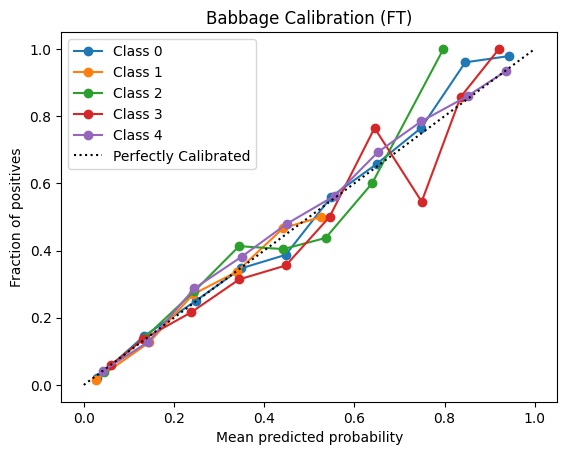

In [ ]:
# Example dataframe with probabilities for 5 classes and actual labels

df = pd.DataFrame(data)

# Number of classes
n_classes = 5

# Create a plot
fig, ax = plt.subplots()

# Compute and plot calibration curve for each class
for i in range(n_classes):
    # Extract probabilities for the current class
    probs = df[f'class_{i}_probs']
    # Create binary labels for the current class
    labels = (df['actual_labels'] == i).astype(int)

    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10, normalize=False)

    # Plot
    ax.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

# Plot perfectly calibrated line
ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("Babbage Calibration (FT)")
ax.legend()

plt.savefig('babbage.png', dpi=600)

plt.show()


In [ ]:
df = pd.DataFrame(data)

In [ ]:
# Predicted probabilities for each class
probs = df[[f'class_{i}_probs' for i in range(n_classes)]].values


a = (df['predicted_token'] == df['actual_labels'].astype(str)).mean()
print(f'Accuracy (generated): {a}')

accuracy = (probs.argmax(-1) == df['actual_labels']).mean()
print(f'Accuracy (top token): {accuracy}')
# Calculate log loss
log_loss_value = log_loss(df['actual_labels'], probs)

print(f"Log Loss: {log_loss_value}")

def calculate_ece(probs, labels, n_bins=10):
    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=n_bins, normalize=False)

    # Calculate the histogram of probabilities
    bin_counts, bin_edges = np.histogram(probs, bins=n_bins, range=(0,1))
    bin_widths = np.diff(bin_edges)

    # Align the bin counts with the number of points used in each bin in the calibration curve
    # This is needed because calibration_curve may return fewer bins if not enough samples
    actual_bins_used = len(prob_true)
    if actual_bins_used < n_bins:
        bin_counts = bin_counts[:actual_bins_used]

    # Calculate ECE as the weighted average of absolute differences
    ece = np.sum(np.abs(prob_pred - prob_true) * bin_counts) / np.sum(bin_counts)
    return ece

# Assuming you have a DataFrame `df` and a number of classes `n_classes`
# ECE for each class
eces = [calculate_ece(df[f'class_{i}_probs'], (df['actual_labels'] == i).astype(int), n_bins=10) for i in range(n_classes)]
average_ece = np.mean(eces)

print(f"ECE per class: {eces}")
print(f"Average ECE: {average_ece}")

Accuracy (generated): 0.5594552121529597
Accuracy (top token): 0.7073511437052558
Log Loss: 0.8295388079586312
ECE per class: [0.011941165449045419, 0.012911575529423786, 0.009528249367511376, 0.009277180271479155, 0.019928434395505897]
Average ECE: 0.012717321002593127


In [ ]:
# Predicted probabilities for each class
probs = df[[f'class_{i}_probs' for i in range(n_classes)]].values
accuracy = (probs.argmax(-1) == df['actual_labels']).mean()

print(f'Accuracy: {accuracy}')
# Calculate log loss
log_loss_value = log_loss(df['actual_labels'], probs)

print(f"Log Loss: {log_loss_value}")

def calculate_ece(probs, labels, n_bins=10):
    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=n_bins, normalize=False)

    # Calculate the histogram of probabilities
    bin_counts, bin_edges = np.histogram(probs, bins=n_bins, range=(0,1))
    bin_widths = np.diff(bin_edges)

    # Align the bin counts with the number of points used in each bin in the calibration curve
    # This is needed because calibration_curve may return fewer bins if not enough samples
    actual_bins_used = len(prob_true)
    if actual_bins_used < n_bins:
        bin_counts = bin_counts[:actual_bins_used]

    # Calculate ECE as the weighted average of absolute differences
    ece = np.sum(np.abs(prob_pred - prob_true) * bin_counts) / np.sum(bin_counts)
    return ece

# Assuming you have a DataFrame `df` and a number of classes `n_classes`
# ECE for each class
eces = [calculate_ece(df[f'class_{i}_probs'], (df['actual_labels'] == i).astype(int), n_bins=10) for i in range(n_classes)]
average_ece = np.mean(eces)

print(f"ECE per class: {eces}")
print(f"Average ECE: {average_ece}")

Accuracy: 0.7073511437052558
Log Loss: 0.8295387361482707
ECE per class: [0.011941004373774244, 0.012911764913034834, 0.009528137342639298, 0.009277618857687605, 0.019893728784770203]
Average ECE: 0.012710450854381236


In [ ]:
gpt_3_5_data = {
    'class_0_probs': [],
    'class_1_probs': [],
    'class_2_probs': [],
    'class_3_probs': [],
    'class_4_probs': [],
    'actual_labels': []
}

for test in tqdm(test_sample):
    _data = {}
    try:
        predicted_label, probs = run_ft_model(test['review']+'\n###\n', 'ft:gpt-3.5-turbo-0125:personal::9PdLZ86e', chat=True, system='') # gpt3. no systme 2 epoch
    except:
        continue
    for key, prob in probs.items():
        if str(key.lower().strip()) in ['0', '1', '2', '3', '4']:
            _data[f'class_{key.lower().strip()}_probs'] = prob
    if len(_data) >= 5:
        for key, value in _data.items():
            gpt_3_5_data[key].append(value)
        gpt_3_5_data['actual_labels'].append(test['star'])


  0%|          | 0/5762 [00:00<?, ?it/s]

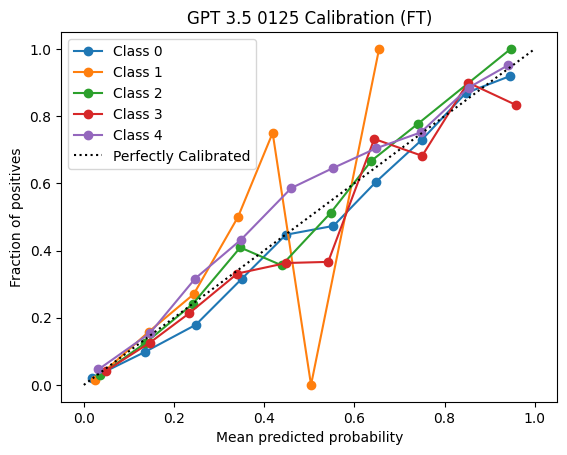

In [ ]:
# Example dataframe with probabilities for 5 classes and actual labels

df = pd.DataFrame(gpt_3_5_data)

# Number of classes
n_classes = 5

# Create a plot
fig, ax = plt.subplots()

# Compute and plot calibration curve for each class
for i in range(n_classes):
    # Extract probabilities for the current class
    probs = df[f'class_{i}_probs']
    # Create binary labels for the current class
    labels = (df['actual_labels'] == i).astype(int)

    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10, normalize=False)

    # Plot
    ax.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

# Plot perfectly calibrated line
ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("GPT 3.5 0125 Calibration (FT)")
ax.legend()

plt.savefig('gpt_ft.png', dpi=600)

plt.show()

In [ ]:
# Predicted probabilities for each class
probs = df[[f'class_{i}_probs' for i in range(n_classes)]].values
accuracy = (probs.argmax(-1) == df['actual_labels']).mean()

print(f'Accuracy: {accuracy}')
# Calculate log loss
log_loss_value = log_loss(df['actual_labels'], probs)

print(f"Log Loss: {log_loss_value}")

def calculate_ece(probs, labels, n_bins=10):
    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=n_bins, normalize=False)

    # Calculate the histogram of probabilities
    bin_counts, bin_edges = np.histogram(probs, bins=n_bins, range=(0,1))
    bin_widths = np.diff(bin_edges)

    # Align the bin counts with the number of points used in each bin in the calibration curve
    # This is needed because calibration_curve may return fewer bins if not enough samples
    actual_bins_used = len(prob_true)
    if actual_bins_used < n_bins:
        bin_counts = bin_counts[:actual_bins_used]

    # Calculate ECE as the weighted average of absolute differences
    ece = np.sum(np.abs(prob_pred - prob_true) * bin_counts) / np.sum(bin_counts)
    return ece

# Assuming you have a DataFrame `df` and a number of classes `n_classes`
# ECE for each class
eces = [calculate_ece(df[f'class_{i}_probs'], (df['actual_labels'] == i).astype(int), n_bins=10) for i in range(n_classes)]
average_ece = np.mean(eces)

print(f"ECE per class: {eces}")
print(f"Average ECE: {average_ece}")

Accuracy: 0.7294342242276988
Log Loss: 0.7763683281332503
ECE per class: [0.012396305102395009, 0.013063910100659364, 0.00998414175055592, 0.019263380948142183, 0.03495337035751499]
Average ECE: 0.017932221651853493


In [ ]:
non_ft_gpt_3_5_data = {
    'class_0_probs': [],
    'class_1_probs': [],
    'class_2_probs': [],
    'class_3_probs': [],
    'class_4_probs': [],
    'actual_labels': []
}

for test in tqdm(test_sample):
    _data = {}
    try:
        predicted_label, probs = run_ft_model(
            f'Please classify this app review with 0-4 where 0 means they hated it, 2 means they kind of liked it, and 4 means they loved it.\n\nReview: {test["review"]}\nRating (0, 1, 2, 3, or 4):',
            'gpt-3.5-turbo-0125', chat=True, system='')
    except:
        continue
    for key, prob in probs.items():
        if str(key.lower().strip()) in ['0', '1', '2', '3', '4'] and f'class_{key.lower().strip()}_probs' not in _data:
            _data[f'class_{key.lower().strip()}_probs'] = prob
    if len(_data) >= 5:
        for key, value in _data.items():
            non_ft_gpt_3_5_data[key ].append(value)
        non_ft_gpt_3_5_data['actual_labels'].append(test['star'])


  0%|          | 0/5762 [00:00<?, ?it/s]

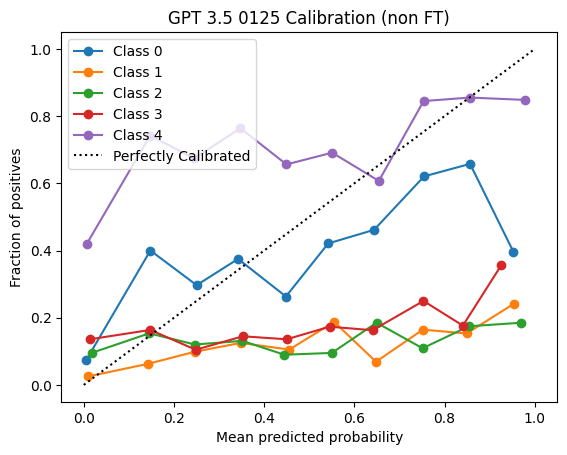

In [ ]:
# Example dataframe with probabilities for 5 classes and actual labels

df = pd.DataFrame(non_ft_gpt_3_5_data)

# Number of classes
n_classes = 5

# Create a plot
fig, ax = plt.subplots()

# Compute and plot calibration curve for each class
for i in range(n_classes):
    # Extract probabilities for the current class
    probs = df[f'class_{i}_probs']
    # Create binary labels for the current class
    labels = (df['actual_labels'] == i).astype(int)

    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10, normalize=False)

    # Plot
    ax.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

# Plot perfectly calibrated line
ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("GPT 3.5 0125 Calibration (non FT)")
ax.legend()

plt.savefig('gpt_non_ft.png', dpi=600)

plt.show()

In [ ]:
predicted_label = []
# for i, row in df.iterrows():
    # print(np.array([row['class_0_probs'], row['class_1_probs'], row['class_2_probs'], row['class_3_probs'], row['class_4_probs']]).argmax())
predicted_labels = [np.array([row['class_0_probs'], row['class_1_probs'], row['class_2_probs'], row['class_3_probs'], row['class_4_probs']]).argmax() for i, row in df.iterrows()]

(np.array(predicted_labels)==df['actual_labels']).mean()

0.3401563081503536

In [ ]:
# Predicted probabilities for each class
probs = df[[f'class_{i}_probs' for i in range(n_classes)]].values
accuracy = (probs.argmax(-1) == df['actual_labels']).mean()

print(f'Accuracy: {accuracy}')
# Calculate log loss
log_loss_value = log_loss(df['actual_labels'], probs)

print(f"Log Loss: {log_loss_value}")

def calculate_ece(probs, labels, n_bins=10):
    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=n_bins, normalize=False)

    # Calculate the histogram of probabilities
    bin_counts, bin_edges = np.histogram(probs, bins=n_bins, range=(0,1))
    bin_widths = np.diff(bin_edges)

    # Align the bin counts with the number of points used in each bin in the calibration curve
    # This is needed because calibration_curve may return fewer bins if not enough samples
    actual_bins_used = len(prob_true)
    if actual_bins_used < n_bins:
        bin_counts = bin_counts[:actual_bins_used]

    # Calculate ECE as the weighted average of absolute differences
    ece = np.sum(np.abs(prob_pred - prob_true) * bin_counts) / np.sum(bin_counts)
    return ece

# Assuming you have a DataFrame `df` and a number of classes `n_classes`
# ECE for each class
eces = [calculate_ece(df[f'class_{i}_probs'], (df['actual_labels'] == i).astype(int), n_bins=10) for i in range(n_classes)]
average_ece = np.mean(eces)

print(f"ECE per class: {eces}")
print(f"Average ECE: {average_ece}")

Accuracy: 0.3401563081503536
Log Loss: 4.3908020170346
ECE per class: [0.09067929289170082, 0.14689553033122446, 0.2923829251953852, 0.15829091179754376, 0.3465911164867883]
Average ECE: 0.2069679553405285


In [ ]:
from transformers import AutoModelForSequenceClassification

MODEL_NAME = "profoz/distilbert-base-cased-finetuned-stars"
distilbert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5).to(0)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
distilbert.config.id2label = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}

In [ ]:
bert_pipeline = pipeline('text-classification', model=distilbert, tokenizer=tokenizer)
bert_pipeline('I hate this thing', return_all_scores=True)

[[{'label': '0', 'score': 0.8580503463745117},
  {'label': '1', 'score': 0.03356441855430603},
  {'label': '2', 'score': 0.013912541791796684},
  {'label': '3', 'score': 0.009098300710320473},
  {'label': '4', 'score': 0.08537442237138748}]]

In [ ]:
bert_data = {
    'class_0_probs': [],
    'class_1_probs': [],
    'class_2_probs': [],
    'class_3_probs': [],
    'class_4_probs': [],
    'actual_labels': []
}

for test in tqdm(test_sample): # I could do this in batches I know
    try:
        probs = bert_pipeline(test['review'], return_all_scores=True)[0]
    except:
        continue

    for prob in probs:
        bert_data[f'class_{prob["label"]}_probs'].append(prob['score'])
    bert_data['actual_labels'].append(test['star'])

  0%|          | 0/5762 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


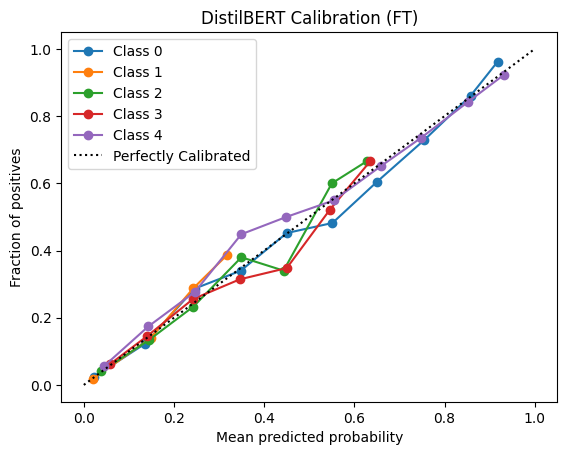

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Example dataframe with probabilities for 5 classes and actual labels

df = pd.DataFrame(bert_data)

# Number of classes
n_classes = 5

# Create a plot
fig, ax = plt.subplots()

# Compute and plot calibration curve for each class
for i in range(n_classes):
    # Extract probabilities for the current class
    probs = df[f'class_{i}_probs']
    # Create binary labels for the current class
    labels = (df['actual_labels'] == i).astype(int)

    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10, normalize=False)

    # Plot
    ax.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

# Plot perfectly calibrated line
ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("DistilBERT Calibration (FT)")
ax.legend()

plt.savefig('bert_scores.png', dpi=600)

plt.show()

In [ ]:
# Predicted probabilities for each class
probs = df[[f'class_{i}_probs' for i in range(n_classes)]].values

# Calculate log loss
log_loss_value = log_loss(df['actual_labels'], probs)
accuracy = (probs.argmax(-1) == df['actual_labels']).mean()

print(f'Accuracy: {accuracy}')
print(f"Log Loss: {log_loss_value}")

def calculate_ece(probs, labels, n_bins=10):
    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=n_bins, normalize=False)

    # Calculate the histogram of probabilities
    bin_counts, bin_edges = np.histogram(probs, bins=n_bins, range=(0,1))
    bin_widths = np.diff(bin_edges)

    # Align the bin counts with the number of points used in each bin in the calibration curve
    # This is needed because calibration_curve may return fewer bins if not enough samples
    actual_bins_used = len(prob_true)
    if actual_bins_used < n_bins:
        bin_counts = bin_counts[:actual_bins_used]

    # Calculate ECE as the weighted average of absolute differences
    ece = np.sum(np.abs(prob_pred - prob_true) * bin_counts) / np.sum(bin_counts)
    return ece

# Assuming you have a DataFrame `df` and a number of classes `n_classes`
# ECE for each class
eces = [calculate_ece(df[f'class_{i}_probs'], (df['actual_labels'] == i).astype(int), n_bins=10) for i in range(n_classes)]
average_ece = np.mean(eces)

print(f"ECE per class: {eces}")
print(f"Average ECE: {average_ece}")

Accuracy: 0.7087816730301979
Log Loss: 0.828313703112158
ECE per class: [0.007650817078975451, 0.005718088775521394, 0.0060034777801186495, 0.008513987193343765, 0.015525377459768473]
Average ECE: 0.008682349657545546


In [ ]:
df['actual_labels'].value_counts()

<Axes: xlabel='actual_labels'>

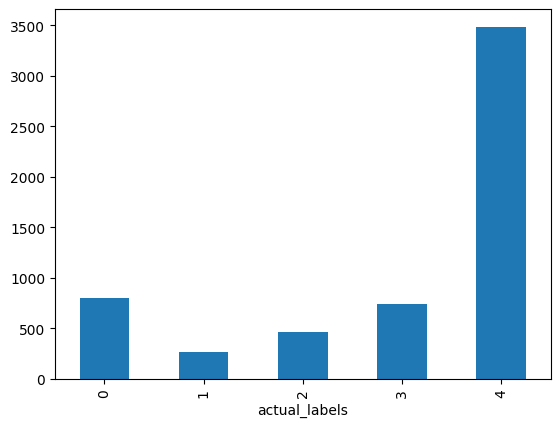

In [ ]:
df['actual_labels'].value_counts().sort_index().plot(kind='bar')

In [ ]:
dataset['train']

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 172839
})

In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

docs = dataset['train']['review']
doc_emb = model.encode(docs, batch_size=32, show_progress_bar=True)

doc_emb.shape  #  == (n, 768)

Batches:   0%|          | 0/5402 [00:00<?, ?it/s]

(172839, 768)

In [ ]:
from sentence_transformers import util

k = 5

print(test_sample[0]['review'])

query_emb = model.encode(test_sample[0]['review'])
scores = util.dot_score(query_emb, doc_emb)[0].cpu().tolist()
# Retrieve the corresponding examples from the dataset
[dataset['train'][int(_)] for _ in np.argsort(scores)[-k:][::-1]]

Does what it should.


[{'package_name': 'com.colinmcdonough.android.torch',
  'review': 'Does exactly what it should.',
  'date': 'July 23 2015',
  'star': 4},
 {'package_name': 'org.isoron.uhabits',
  'review': 'Does what it should',
  'date': 'October 23 2016',
  'star': 4},
 {'package_name': 'de.danoeh.antennapod',
  'review': 'Does what it should do',
  'date': 'January 07 2017',
  'star': 4},
 {'package_name': 'com.nolanlawson.logcat',
  'review': 'Does what it is supposed to.',
  'date': 'January 22 2017',
  'star': 4},
 {'package_name': 'dev.ukanth.ufirewall',
  'review': 'It does what it should be',
  'date': 'February 02 2017',
  'star': 4}]

In [ ]:
few_shot_non_ft_gpt_3_5_data = {
    'class_0_probs': [],
    'class_1_probs': [],
    'class_2_probs': [],
    'class_3_probs': [],
    'class_4_probs': [],
    'actual_labels': [],
    'predicted_token': []
}

for test in tqdm(test_sample):
    _data = {}

    query_emb = model.encode(test['review'])
    scores = util.dot_score(query_emb, doc_emb)[0].cpu().tolist()
    # Retrieve the corresponding examples from the dataset
    examples = [dataset['train'][int(_)] for _ in np.argsort(scores)[-k:][::-1]]
    examples_str = '\n--\n'.join([f'Review: {e["review"]}\nRating: {e["star"]}' for e in examples]).strip()
    try:
        predicted_label, probs = run_ft_model(
            f'Please classify these app reviews with 0-4 \n--\n{examples_str}\n--\nReview: {test["review"]}\nRating:',
            'gpt-3.5-turbo-0125', chat=True, system=''
            )
    except:
        continue
    for key, prob in probs.items():
        if str(key.lower().strip()) in ['0', '1', '2', '3', '4'] and f'class_{key.lower().strip()}_probs' not in _data:
            _data[f'class_{key.lower().strip()}_probs'] = prob
    if len(_data) >= 5:
        for key, value in _data.items():
            few_shot_non_ft_gpt_3_5_data[key].append(value)
        few_shot_non_ft_gpt_3_5_data['actual_labels'].append(test['star'])
        few_shot_non_ft_gpt_3_5_data['predicted_token'].append(predicted_label)


  0%|          | 0/5762 [00:00<?, ?it/s]

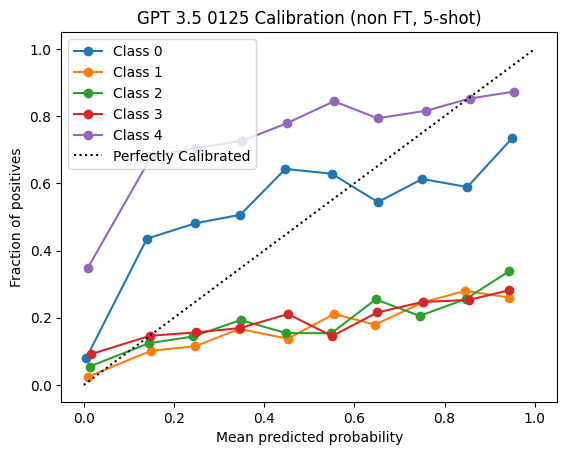

In [ ]:
# Example dataframe with probabilities for 5 classes and actual labels

df = pd.DataFrame({k: v for k, v in few_shot_non_ft_gpt_3_5_data.items() if k != 'predicted_token'})

# Number of classes
n_classes = 5

# Create a plot
fig, ax = plt.subplots()

# Compute and plot calibration curve for each class
for i in range(n_classes):
    # Extract probabilities for the current class
    probs = df[f'class_{i}_probs']
    # Create binary labels for the current class
    labels = (df['actual_labels'] == i).astype(int)

    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10, normalize=False)

    # Plot
    ax.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

# Plot perfectly calibrated line
ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("GPT 3.5 0125 Calibration (non FT, 5-shot)")
ax.legend()

plt.savefig('gpt_5_shot.png', dpi=600)

plt.show()

In [ ]:
pd.Series(few_shot_non_ft_gpt_3_5_data['predicted_token']) == pd.Series(few_shot_non_ft_gpt_3_5_data['actual_labels'])

ValueError: Can only compare identically-labeled Series objects

In [ ]:
# Predicted probabilities for each class
probs = df[[f'class_{i}_probs' for i in range(n_classes)]].values
accuracy = (probs.argmax(-1) == df['actual_labels']).mean()

print(f'Accuracy (top token): {accuracy}')
# a = (pd.Series(few_shot_non_ft_gpt_3_5_data['predicted_token']) == df['actual_labels'].astype(str)[:len(few_shot_non_ft_gpt_3_5_data['predicted_token'])]).mean()
# print(f'Accuracy (generated): {a}')
# Calculate log loss
log_loss_value = log_loss(df['actual_labels'], probs)

print(f"Log Loss: {log_loss_value}")

def calculate_ece(probs, labels, n_bins=10):
    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=n_bins, normalize=False)

    # Calculate the histogram of probabilities
    bin_counts, bin_edges = np.histogram(probs, bins=n_bins, range=(0,1))
    bin_widths = np.diff(bin_edges)

    # Align the bin counts with the number of points used in each bin in the calibration curve
    # This is needed because calibration_curve may return fewer bins if not enough samples
    actual_bins_used = len(prob_true)
    if actual_bins_used < n_bins:
        bin_counts = bin_counts[:actual_bins_used]

    # Calculate ECE as the weighted average of absolute differences
    ece = np.sum(np.abs(prob_pred - prob_true) * bin_counts) / np.sum(bin_counts)
    return ece

# Assuming you have a DataFrame `df` and a number of classes `n_classes`
# ECE for each class
eces = [calculate_ece(df[f'class_{i}_probs'], (df['actual_labels'] == i).astype(int), n_bins=10) for i in range(n_classes)]
average_ece = np.mean(eces)

print(f"ECE per class: {eces}")
print(f"Average ECE: {average_ece}")

Accuracy (top token): 0.5242255758538522
Log Loss: 2.2580764282857
ECE per class: [0.09493193010325662, 0.06264184074662434, 0.09240138204924542, 0.1563492930897538, 0.25714156076250994]
Average ECE: 0.132693201350278
